In [10]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, \
                            auc,\
                            f1_score, \
                            recall_score, \
                            precision_score, \
                            classification_report

import sys
sys.path.append("../src")
# from utils import prepare_U_L_data, \
#                   self_trainer, \
#                   data_sampler, \
#                   evaluate_model
from semi_supervised import SemiSupervisedData

In [11]:
n_samples=1500
n_features=2
data = make_classification(n_samples=n_samples,
                           n_classes=2,
                           n_features=n_features,
                           n_clusters_per_class=1,
                           n_informative=n_features, 
                           n_redundant=0, 
                           n_repeated=0,
                           flip_y=0.0,
                           random_state=42
                          )
feature_cols = [f'x{i}' for i in range(1,n_features+1)]
X = pd.DataFrame(data[0], columns = feature_cols)
y = pd.DataFrame(data[1], columns = ['y'])
df = pd.concat([X, y], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
print(df_train.shape)
df.head(3)

(1050, 3)


,x1,x2,y
0,-2.799877,-0.136802,0
1,-1.367893,1.101364,0
2,-1.372660,0.543190,0


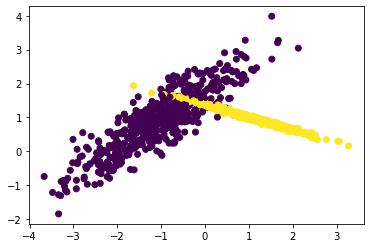

In [12]:
pl.scatter(df_train['x1'], df_train['x2'], c=df_train['y'])

### Perform Analysis using `SemiSupervisedData`

In [21]:
data_semi = SemiSupervisedData.from_dataframe(df_train, feature_cols, 'y')

In [22]:
data_semi.mask(0.6)

In [23]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
cl_self = Pipeline([('self-clf', SelfTrainingClassifier(sgd, threshold=0.95))])

In [31]:
for l_frac in np.linspace(0.1, 1., 5):
    u_frac = 0.3
    x, y, y_mask = data_semi.sample(l_frac=l_frac, u_frac=u_frac)
    cl_self.fit(x, y_mask)
    test_predict = cl_self.predict(df_test[feature_cols])
    report_test = classification_report(df_test['y'], test_predict)

In [25]:
df_test.head()

,x1,x2,y
1116,-0.448572,1.444158,0
1368,0.814463,1.097207,1
422,-0.287189,1.578942,0
413,-1.333552,1.086451,0
451,-0.696371,0.987463,0


In [28]:
train_predict = cl_self.predict(df_train[feature_cols])
test_predict = cl_self.predict(df_test[feature_cols])
report_test = classification_report(df_test['y'], test_predict)
report_train = classification_report(df_train['y'], train_predict)
                

In [29]:
print(report_train)
print(report_test)

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       533
           1       0.90      0.88      0.89       517

    accuracy                           0.89      1050
   macro avg       0.89      0.89      0.89      1050
weighted avg       0.89      0.89      0.89      1050

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       217
           1       0.90      0.88      0.89       233

    accuracy                           0.89       450
   macro avg       0.89      0.89      0.89       450
weighted avg       0.89      0.89      0.89       450



In [17]:
roc_scores = {}
roc_stds = {}
for i, l_frac in enumerate(np.linspace(0.05, 1, 10)):
    roc_scores[i] = []
    roc_stds[i] = []
    for u_frac in np.linspace(0.001, 1, 10):
        roc, roc_std = self_trainer(ml_trainer=cl_self, 
                           feature_cols=feature_cols,
                           target_col='y',
                           df_train=df_out,
                           df_test=df_test,
                           l_frac=l_frac, 
                           u_frac=u_frac, 
                           n_realization=10)
        roc_scores[i].append(roc)
        roc_stds[i].append(roc_std)

Text(0, 0.5, 'Ratio of ROC Improvement')

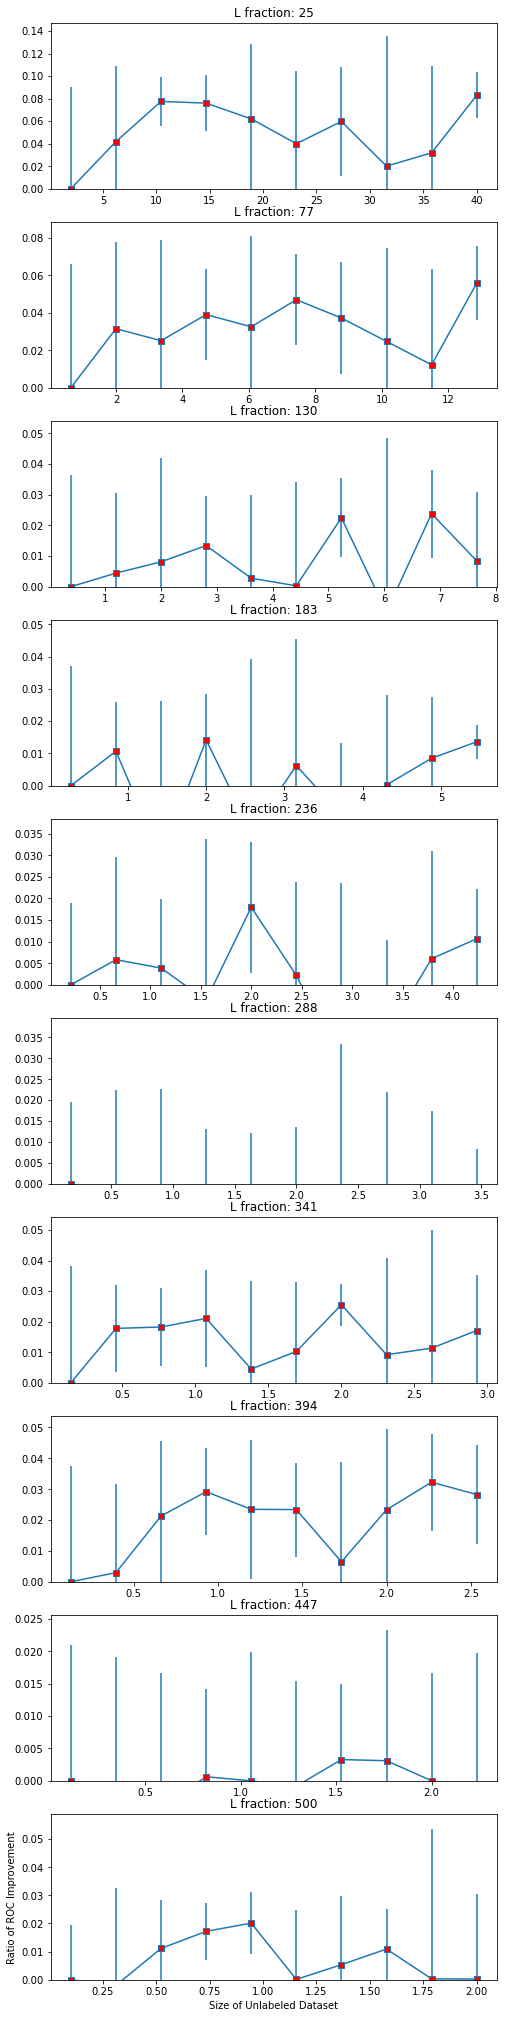

In [26]:
fig, ax = pl.subplots(10, 1, figsize=(8,36))
for i,k in zip(roc_scores.keys(), 500*np.linspace(0.05, 1, 10)):
    l_roc = roc_scores[i][0]
    roc_ratio = (roc_scores[i] - l_roc)/l_roc
    ax[i].errorbar(1000*np.linspace(0.05, 1, 10)/k, roc_ratio, roc_stds[i], 
                   marker='s', mfc='red')
    ax[i].set_title('L fraction: {:}'.format(int(k)))
    ax[i].set_ylim(0., )
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('Ratio of ROC Improvement')

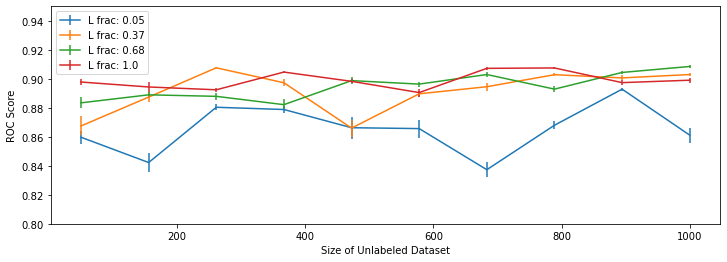

In [9]:
fig, ax = pl.subplots(1, 1, figsize=(12,4))
for i, k in enumerate(roc_scores.keys()):
    if i%3 == 0:
        ax.errorbar(1000*np.linspace(0.05, 1, 10), roc_scores[k], 
                    0.1*np.array(roc_stds[k]), label=f"L frac: {k:2.2}")
    
# ax.set_title('L fraction: {:}'.format(int(k*500)))
ax.set_ylim(0.8, 0.95)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')
pl.legend(loc='best')
pl.savefig("../figs/l_fraction.pdf")

### Effect of Prob. Threshold

In [10]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
roc_scores_ex2 = {}
roc_stds_ex2 = {}
for thrs in np.linspace(0.5, .99, 10):
    cl_self = Pipeline([('self-clf', SelfTrainingClassifier(sgd, threshold=thrs))])
    roc_scores_ex2[thrs] = []
    roc_stds_ex2[thrs] = []
    for u_frac in np.linspace(0.001, 1, 10):
        roc, roc_std = self_trainer(ml_trainer=cl_self, 
                           feature_cols=feature_cols,
                           target_col='y',
                           df_train=df_out,
                           df_test=df_test,
                           l_frac=l_frac, 
                           u_frac=u_frac, 
                           n_realization=20)
        roc_scores_ex2[thrs].append(roc)
        roc_stds_ex2[thrs].append(roc_std)

Text(0, 0.5, 'ROC Score')

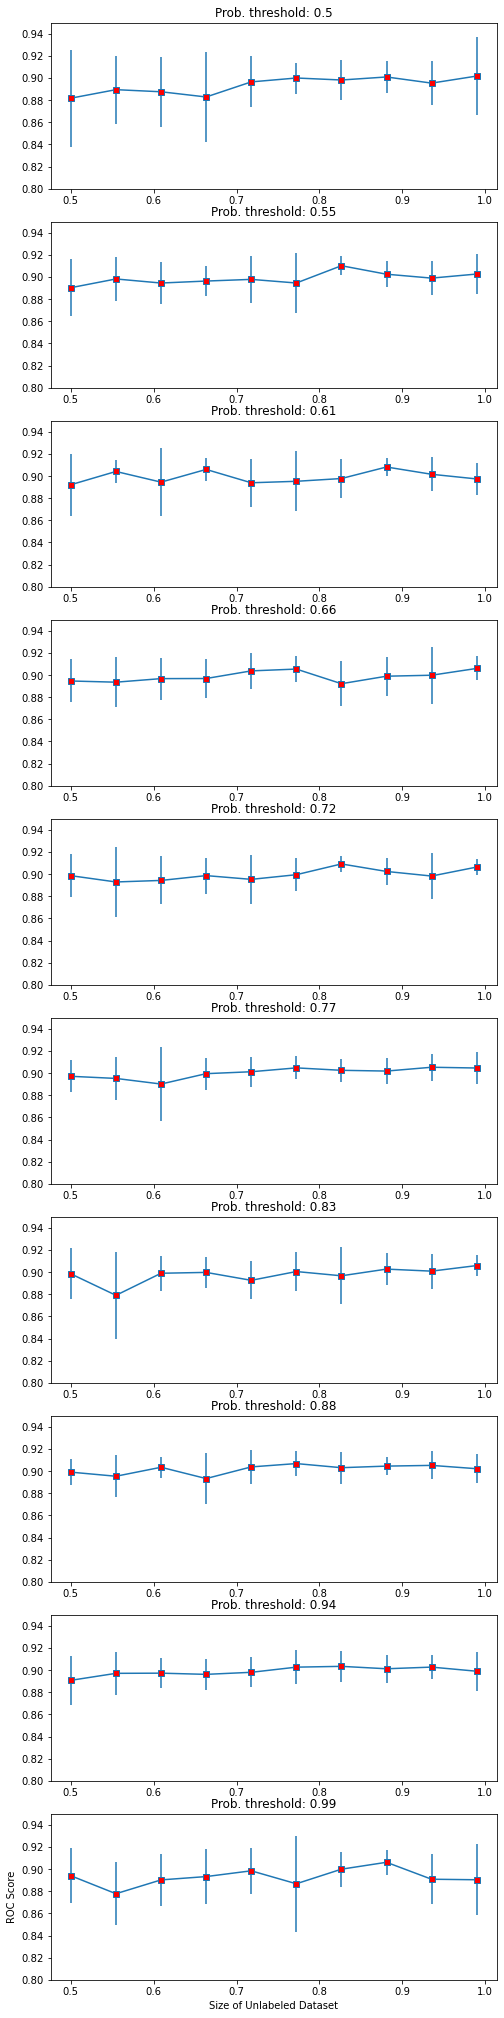

In [11]:
fig, ax = pl.subplots(10, 1, figsize=(8,36))
for i, k in enumerate(roc_scores_ex2.keys()):
    ax[i].errorbar(np.linspace(0.5, 0.99, 10), roc_scores_ex2[k], roc_stds_ex2[k], 
                   marker='s', 
                   mfc='red')
    ax[i].set_title('Prob. threshold: {:.2}'.format(k))
    ax[i].set_ylim(0.8, 0.95)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')

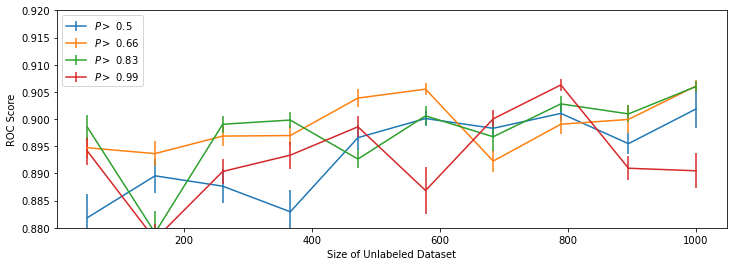

In [12]:
fig, ax = pl.subplots(1, 1, figsize=(12,4))
for i, k in enumerate(roc_scores_ex2.keys()):
    if i%3 == 0:
        ax.errorbar(1000*np.linspace(0.05, 1, 10), roc_scores_ex2[k], 
                    0.1*np.array(roc_stds_ex2[k]), label=r"$P > $ "+ f"{k:2.2}")
    
# ax.set_title('L fraction: {:}'.format(int(k*500)))
ax.set_ylim(0.88, 0.92)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')
pl.legend(loc='best')
pl.savefig("../figs/threshold.pdf")

### Perform Analysis using `SemiSupervisedData`